In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pandas as pd
from scipy.io import loadmat

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import GraphicalLasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer

from pyriemann.classification import MDM, FgMDM, TSclassifier
from pyriemann.clustering import Potato
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.distance import distance
from pyriemann.utils.mean import mean_covariance

from mne.decoding import CSP
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [3]:
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

def isPD2(B):
    """Returns true when input is positive-definite, via Cholesky"""
    if np.any(np.linalg.eigvals(B) < 0.):
        return False
    else: return True

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD2(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

In [4]:
l_freq, h_freq = 8, 30
start, stop = 3, 7.5

subjects = ["P{:02d}T".format(i) for i in range(1, 9)]
path= "../../datasets/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow/parsed_"
sfreq = 512
channel_names = ["F3", "FC3", "C3", "CP3", "P3", "FCz", "CPz", "F4", "FC4", "C4", "CP4", "P4"]
channel_types = 12 * ["eeg"]
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(channel_names, sfreq, channel_types, montage)
tmin = 0.
event_id = {'right':1 , 'left':2}

ep = []
for s in subjects:
    d = loadmat(path+s+".mat", squeeze_me=True)
    labels = d['Labels']
    data = d['RawEEGData']
    events = np.array([[t*10*sfreq, 0, l] for t, l in enumerate(labels)])
    epochs =  mne.EpochsArray(data, info, events, tmin, event_id)
    epochs.set_montage(montage)
    epochs.filter(l_freq=l_freq, h_freq=h_freq, method='iir')
    epochs.crop(tmin=start, tmax=stop)
    ep.append(epochs)
    
subjects = ["P{:02d}E".format(i) for i in range(1, 9)]
event_id = {'unknown':3}
eptest = []
for s in subjects:
    d = loadmat(path+s+".mat", squeeze_me=True)
    data = d['RawEEGData']
    events = np.array([[t*10*sfreq, 0, 3] for t in range(data.shape[0])])
    epochs =  mne.EpochsArray(data, info, events, tmin, event_id)
    epochs.set_montage(montage)
    epochs.filter(l_freq=l_freq, h_freq=h_freq, method='iir')
    epochs.crop(tmin=start, tmax=stop)
    eptest.append(epochs)

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-4-57c187a81ac8>:10: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  info = mne.create_info(channel_names, sfreq, channel_types, montage)


0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 

In [5]:
def load_data(feat, subj, idx, phase):
    if phase == "train":
        if feat == "signal":
            return ep[subj].get_data()[idx]
        elif feat == "Cov":
            d = loadmat("AlphaBetaTogether/Cov_Training_All.mat", squeeze_me=True)
        else: d = loadmat(feat+"_Training_121280.mat", squeeze_me=True)
        X = np.array(np.transpose(d['Mat'+feat][subj, 0], axes=(2, 0, 1)))
        for i in range(80):
            if not isPD2(X[i]): X[i] = nearestPD(X[i])
        return X[idx]
    else:  # train for X < 80 else test 
        if feat == "signal":
            train_ep = ep[subj].get_data()
            test_ep = eptest[subj].get_data()
            return np.concatenate((train_ep, test_ep), axis=0)[idx]
        elif feat == "Cov":
            d1 = loadmat("AlphaBetaTogether/Cov_Training_All.mat", squeeze_me=True)
            d2 = loadmat("AlphaBetaTogether/Cov_Testing.mat", squeeze_me=True)
        else: 
            d1 = loadmat(feat+"_Training_121280.mat", squeeze_me=True)
            d2 = loadmat(feat+"_Testing_121240.mat", squeeze_me=True)
        X1 = np.array(np.transpose(d1['Mat'+feat][subj, 0], axes=(2, 0, 1)))
        X2 = np.array(np.transpose(d2['Mat'+feat][subj], axes=(2, 0, 1)))
        X = np.concatenate((X1, X2), axis=0)
        for i in range(len(X)):
            if not isPD2(X[i]): X[i] = nearestPD(X[i])
        return X[idx]

In [6]:
class FeatConn(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files
    """
    def __init__(self, feat="Cov", subj=0, phase="train"):
        self.feat = feat
        self.subj = subj
        self.phase = phase
    
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        return load_data(self.feat, self.subj, X, self.phase)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
class CovLasso(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files
    """
    def __init__(self, alpha=0.01, mode='cd', tol=1e-4, enet_tol=1e-4, max_iter=100):
        self.alpha = alpha
        self.mode = mode
        self.tol = tol
        self.enet_tol = enet_tol
        self.max_iter = max_iter
        # self.cov = GraphicalLasso(alpha=alpha, mode=mode, tol=tol, enet_tol=enet_tol, max_iter=max_iter)
    
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass
    
    def fit_transform(self, X, y=None):
        Nt, Ne, Ns = X.shape
        covmats = numpy.zeros((Nt, Ne, Ne))
        for i in range(Nt):
            est = GraphicalLasso(alpha=self.alpha, mode=self.mode, tol=self.tol, 
                                 enet_tol=self.enet_tol, max_iter=self.max_iter)
            est.fit(X[i, :, :])
            covmats[i, :, :] = est.covariance_
        return covmats

In [7]:
import numpy

from scipy import stats

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import softmax
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed

from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.distance import distance
from pyriemann.tangentspace import FGDA, TangentSpace

class FgMDM2(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, metric='riemann', tsupdate=False, n_jobs=1):
        """Init."""
        self.metric = metric
        self.n_jobs = n_jobs
        self.tsupdate = tsupdate

        if isinstance(metric, str):
            self.metric_mean = metric

        elif isinstance(metric, dict):
            # check keys
            for key in ['mean', 'distance']:
                if key not in metric.keys():
                    raise KeyError('metric must contain "mean" and "distance"')

            self.metric_mean = metric['mean']

        else:
            raise TypeError('metric must be dict or str')

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self._mdm = MDM(metric=self.metric, n_jobs=self.n_jobs)
        self._fgda = FGDA(metric=self.metric_mean, tsupdate=self.tsupdate)
        cov = self._fgda.fit_transform(X, y)
        self._mdm.fit(cov, y)
        return self

    def predict(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.predict(cov)
    
    def predict_proba(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.predict_proba(cov)
    
    def transform(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.transform(cov)
    
class MDM2(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, metric='riemann', n_jobs=1):
        """Init."""
        # store params for cloning purpose
        self.metric = metric
        self.n_jobs = n_jobs

        if isinstance(metric, str):
            self.metric_mean = metric
            self.metric_dist = metric

        elif isinstance(metric, dict):
            # check keys
            for key in ['mean', 'distance']:
                if key not in metric.keys():
                    raise KeyError('metric must contain "mean" and "distance"')

            self.metric_mean = metric['mean']
            self.metric_dist = metric['distance']

        else:
            raise TypeError('metric must be dict or str')

    def fit(self, X, y, sample_weight=None):
        self.classes_ = numpy.unique(y)

        if sample_weight is None:
            sample_weight = numpy.ones(X.shape[0])

        if self.n_jobs == 1:
            self.covmeans_ = [mean_covariance(X[y == l], metric=self.metric_mean,
                                    sample_weight=sample_weight[y == l])
                                        for l in self.classes_]
        else:
            self.covmeans_ = Parallel(n_jobs=self.n_jobs)(
                delayed(mean_covariance)(X[y == l], metric=self.metric_mean,
                                         sample_weight=sample_weight[y == l])
                for l in self.classes_)

        return self

    def _predict_distances(self, covtest):
        """Helper to predict the distance. equivalent to transform."""
        Nc = len(self.covmeans_)

        if self.n_jobs == 1:
            dist = [distance(covtest, self.covmeans_[m], self.metric_dist)
                    for m in range(Nc)]
        else:
            dist = Parallel(n_jobs=self.n_jobs)(delayed(distance)(
                covtest, self.covmeans_[m], self.metric_dist)
                for m in range(Nc))

        dist = numpy.concatenate(dist, axis=1)
        return dist

    def predict(self, covtest):
        dist = self._predict_distances(covtest)
        return self.classes_[dist.argmin(axis=1)]

    def transform(self, X):
        return self._predict_distances(X)

    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

    def predict_proba(self, X):
        return softmax(-self._predict_distances(X))

In [273]:
pipelines = {}
pipelines['fgMDM-Coh'] = make_pipeline(
    FeatConn("Coh", s),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))
pipelines['fgMDM-PLV'] = make_pipeline(
    FeatConn("PLV", s),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))
pipelines['fgMDM-Cov'] = make_pipeline(
    FeatConn("Cov", s),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))

pipelines['MDM-ICoh'] = make_pipeline(
    FeatConn("ICoh", s),
    MDM(metric='logeuclid', n_jobs=1))
pipelines['MDM-AEC'] = make_pipeline(
    FeatConn("AEC", s),
    MDM(metric='logeuclid', n_jobs=1))

param_svc = {'C': np.logspace(-2, 2, 10)}
gssvc = GridSearchCV(SVC(kernel='linear'), param_svc, cv=3)
pipelines['CSP-SVM'] = make_pipeline(
    FeatConn("signal", s),
    CSP(n_components=6), 
    gssvc)
pipelines['CSP-LDA'] = make_pipeline(
    FeatConn("signal", 0s,
    CSP(n_components=6), 
    LDA())

pipelines['fgMDM-Lasso'] = make_pipeline(
    FeatConn("signal", s),
    CovLasso(max_iter=1000),
    FgMDM2(metric='riemann', tsupdate=True, n_jobs=1))


estimators = [('cov', pipelines['fgMDM-Cov']),
              ('coh', pipelines['fgMDM-Coh']),
              ('plv', pipelines['fgMDM-PLV'])            
             ]
# final_estimator = LogisticRegression()
final_estimator = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, intercept_scaling=1000., solver='saga')


# Pas terrible...
# final_estimator = GradientBoostingClassifier(random_state=42)
# from sklearn.linear_model import SGDClassifier
# final_estimator = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=0.1)

cvkf = StratifiedKFold(n_splits=4, shuffle=True)
scl = StackingClassifier(
        estimators=estimators,
        cv = cvkf, n_jobs = 1,
        final_estimator=final_estimator,
        stack_method='predict_proba')
pipelines['Ensemble'] = scl

In [8]:
mne.set_log_level('ERROR')

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [18]:
n_jobs = -1
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(8):
    y_train_all.append(d_['MatCoh'][i, 1])

all_res = []
for s in trange(8):
    X = np.array([i for i in range(80)])
    y = y_train_all[s]
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    th = 5 # 4
    mat = FeatConn("Coh", s).fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcoh = (pt.predict(mat) == 1)
    mat = FeatConn("Cov", s).fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcov = (pt.predict(mat) == 1)
    mat = FeatConn("PLV", s).fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfplv = (pt.predict(mat) == 1)
    #mat = FeatConn("AEC", s).fit_transform(X)
    #pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    #atfaec = (pt.predict(mat) == 1)
    #mat = FeatConn("ICoh", s).fit_transform(X)
    #pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    #atfico = (pt.predict(mat) == 1)
    atf = np.logical_and(atfcoh, np.logical_and(atfcov, atfplv))
    #atf = np.logical_and(atfico, np.logical_and(atfaec, np.logical_and(atfcoh, np.logical_and(atfcov, atfplv))))
    print ("removed ", len(X)-atf.sum(), "artefacts")
    X = X[atf]
    y = y[atf]

    pipelines = {}
    pipelines['fgMDM-Coh'] = make_pipeline(
        FeatConn("Coh", s),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-PLV'] = make_pipeline(
        FeatConn("PLV", s),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-Cov'] = make_pipeline(
        FeatConn("Cov", s),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))

    #pipelines['MDM-ICoh'] = make_pipeline(
    #    FeatConn("ICoh", s),
    #    MDM(metric='riemann', n_jobs=1))
    #pipelines['MDM-AEC'] = make_pipeline(
    #    FeatConn("AEC", s),
    #    MDM(metric='riemann', n_jobs=1))
    
    pipelines['CSP-LDA'] = make_pipeline(
        FeatConn("signal", s),
        CSP(n_components=6, reg='ledoit_wolf'), 
        LDA())
    
    estimators = [('cov', pipelines['fgMDM-Cov']),
                  ('coh', pipelines['fgMDM-Coh']),
                  ('plv', pipelines['fgMDM-PLV'])
                 ]
#    final_estimator = LogisticRegression(penalty='elasticnet', 
#                                         l1_ratio=0.1, intercept_scaling=1000., 
#                                         solver='saga')
    final_estimator = RidgeClassifier(class_weight="balanced")
    cvkf = StratifiedKFold(n_splits=5, shuffle=True)
    scl = StackingClassifier(estimators=estimators,
            cv=cvkf, n_jobs=n_jobs, final_estimator=final_estimator,
            stack_method='predict_proba')
    pipelines['Ensemble'] = scl
    
    for p in tqdm(pipelines, leave=False):
        scores = cross_val_score(pipelines[p], X, y, n_jobs=n_jobs,
                                 scoring=make_scorer(cohen_kappa_score), 
                                 cv=RepeatedStratifiedKFold(n_splits=4, 
                                                            n_repeats=10,
                                                            random_state=1))
        for sc in scores:
            res = {'subject': str(s+1),
                   'score': sc,
                   'estimator': p}
            all_res.append(res)
df_strat = pd.DataFrame(all_res)

removed  1 artefacts


removed  0 artefacts


removed  0 artefacts


removed  0 artefacts


removed  0 artefacts


removed  1 artefacts


removed  0 artefacts


removed  1 artefacts


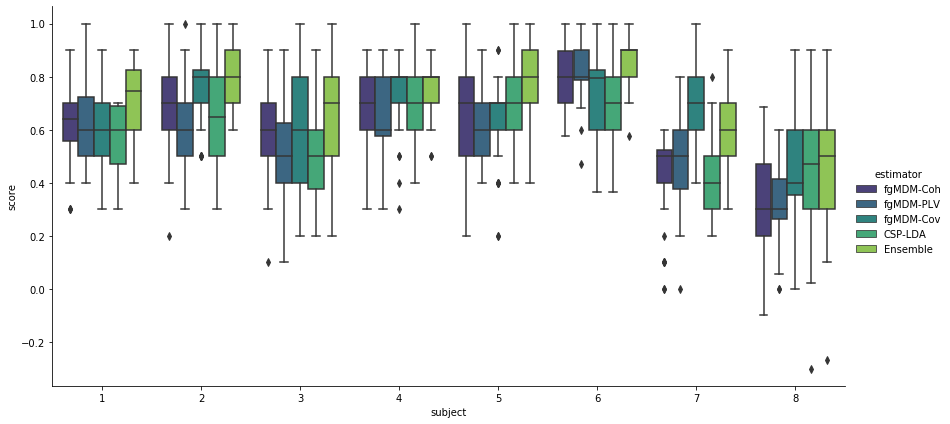

In [19]:
sns.catplot(x='subject', y='score', hue='estimator', kind="box", 
            data=df_strat, palette='viridis', height=6, aspect=2)
plt.savefig("ensemble-subject.png")

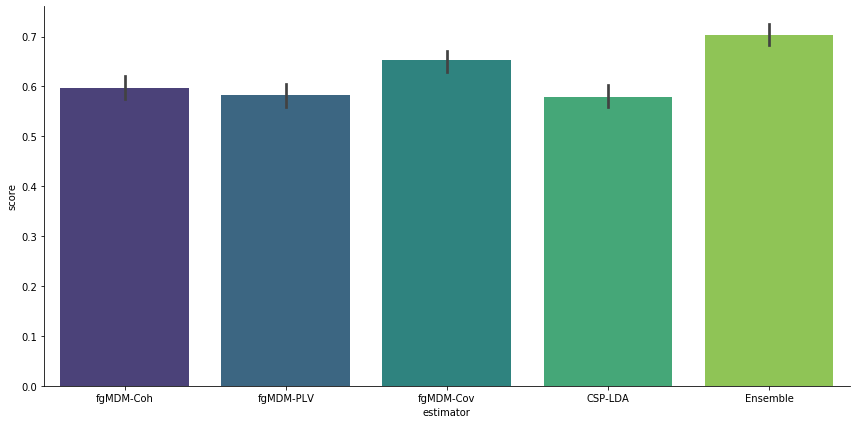

In [20]:
sns.catplot(x='estimator', y='score', kind='bar', data=df_strat, 
            height=6, aspect=2, palette="viridis")
plt.savefig("ensemble-classif.png")

# Results

In [16]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
CSP+LDA on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Coh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Cov']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-PLV']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'CSP-LDA']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy())*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 59.69
FgMDM on covariance       = 65.19
FgMDM on phase-lock value = 58.19
CSP+LDA on covariance     = 57.93
---------------------------------
Ensemble classifier       = 68.00

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1000.0,

In [53]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
CSP+LDA on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Coh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Cov']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-PLV']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'CSP-LDA']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy())*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 59.69
FgMDM on covariance       = 65.19
FgMDM on phase-lock value = 58.19
CSP+LDA on covariance     = 57.93
---------------------------------
Ensemble classifier       = 70.24

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', phase='train', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', phase='train', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', phase='train', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=-1, tsupdate=True))],
         verbose=False))]
RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
           

# Prediction cross-subjects

In [50]:
n_jobs = 1
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(8):
    y_train_all.append(d_['MatCoh'][i, 1])

cross_subj = []
for s in trange(8):
    X = np.array([i for i in range(80)])
    y_train = y_train_all[s]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    # Patate
    th = 3 # 4
    mat = FeatConn("Coh", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcoh = (pt.predict(mat) == 1)
    mat = FeatConn("PLV", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfplv = (pt.predict(mat) == 1)
    mat = FeatConn("Cov", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcov = (pt.predict(mat) == 1)
    atf = np.logical_and(atfcoh, np.logical_and(atfcov, atfplv))
    print ("removed ", len(X)-atf.sum(), "artefacts")
    X_train = X[:80]
    X_train = X_train[atf[:80]]
    # On n'applique pas la patate pour X_test car on doit prédire tout
    # X_test = X[60:]
    y_train = y_train[atf[:80]]

    pipelines = {}
    pipelines['fgMDM-Coh'] = make_pipeline(
        FeatConn("Coh", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-PLV'] = make_pipeline(
        FeatConn("PLV", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-Cov'] = make_pipeline(
        FeatConn("Cov", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['CSP-LDA'] = make_pipeline(
        FeatConn("signal", s),
        CSP(n_components=6, reg='ledoit_wolf'), 
        LDA())
    estimators = [('cov', pipelines['fgMDM-Cov']),
                  ('coh', pipelines['fgMDM-Coh']),
                  ('plv', pipelines['fgMDM-PLV'])
                 ]
    final_estimator = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, intercept_scaling=1000., solver='saga') # RidgeClassifier(class_weight="balanced")
    cvkf = StratifiedKFold(n_splits=5, shuffle=True)
    scl = StackingClassifier(estimators=estimators,
            cv=cvkf, n_jobs=n_jobs, final_estimator=final_estimator,
            stack_method='predict_proba')
    pipelines['Ensemble'] = scl

    pipelines['CSP-LDA'].fit(X_train, y_train)
    pipelines['Ensemble'].fit(X_train, y_train)
    cross_subj.append({'X_train': X_train, 'y_train': y_train, 
                       'pipelines': pipelines, 
                       'mean': mean_covariance(mat[atf], metric='riemann', sample_weight=None)})

removed  3 artefacts
removed  1 artefacts
removed  4 artefacts
removed  3 artefacts
removed  2 artefacts
removed  2 artefacts
removed  0 artefacts
removed  8 artefacts



In [32]:
all_res = []
for source in trange(8):
    for target in trange(8, leave=False):
        if source == target: continue
        dc = distance(cross_subj[source]['mean'], cross_subj[target]['mean'], metric='riemann')
        ycsp = cross_subj[source]['pipelines']['CSP-LDA'].predict(cross_subj[target]['X_train'])
        res = {'source': str(source+1), 'target': str(target+1),
               'score': cohen_kappa_score(ycsp, cross_subj[target]['y_train']),
               'estimator': 'CSP-LDA', 'dist': dc}
        all_res.append(res)
        yens = cross_subj[source]['pipelines']['Ensemble'].predict(cross_subj[target]['X_train'])
        res = {'source': str(source+1), 'target': str(target+1),
               'score': cohen_kappa_score(yens, cross_subj[target]['y_train']),
               'estimator': 'Ensemble', 'dist': dc}
        all_res.append(res)
df_cross = pd.DataFrame(all_res)

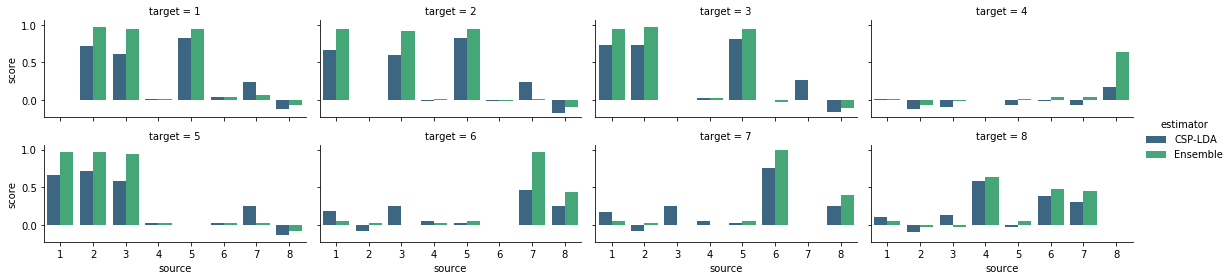

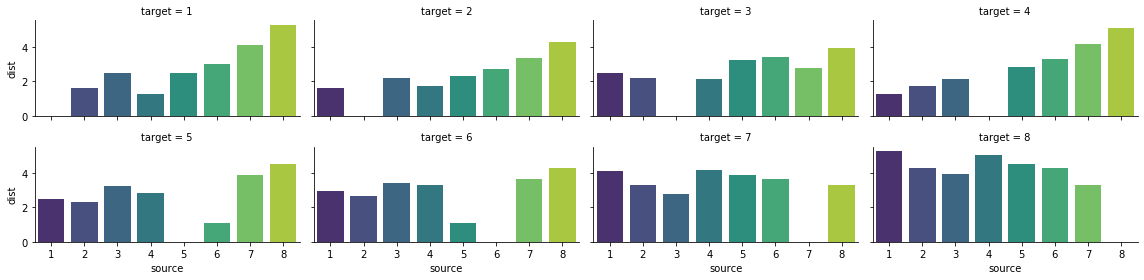

In [45]:
sns.catplot(x='source', y='score', hue='estimator', col='target', col_wrap=4,
            kind="bar", data=df_cross,
            # data=df_cross[df_cross['estimator'] == 'CSP-LDA'], 
            palette='viridis', height=2, aspect=2)

sns.catplot(x='source', y='dist', col='target', col_wrap=4,
            kind="bar", data=df_cross,
            # data=df_cross[df_cross['estimator'] == 'CSP-LDA'], 
            palette='viridis', height=2, aspect=2)

#plt.savefig("ensemble-subject.png")

## Voting classifier

In [53]:
from sklearn.ensemble import VotingClassifier

all_res = []
for target in trange(8):
    est = [('ens'+str(source), cross_subj[source]['pipelines']['Ensemble'])
           for source in range(8) if source != target]
    w = [1./distance(cross_subj[source]['mean'], cross_subj[target]['mean'], metric='riemann')
         for source in range(8) if source != target]
    voting_clf = VotingClassifier(estimators=est, voting='soft', weights=w)
    voting_clf.fit(X_train, y_train)
    voting_clf.estimators_ = [clf[1] for clf in est]
    
    
    yp = voting_clf.predict(cross_subj[target]['X_train'])
    res = {'target': str(target+1),
           'score': cohen_kappa_score(yp, cross_subj[target]['y_train']),
           'estimator': 'Voting', 'dist': 1./dc}
    all_res.append(res)
df_cross = pd.DataFrame(all_res)

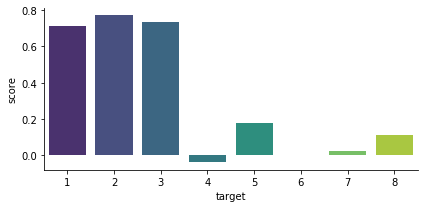

In [57]:
sns.catplot(x='target', y='score',
            kind="bar", data=df_cross,
            # data=df_cross[df_cross['estimator'] == 'CSP-LDA'], 
            palette='viridis', height=3, aspect=2)

## Closer classifier

In [58]:
all_res = []

for target in trange(8):
    best = np.argmin(np.array([distance(cross_subj[source]['mean'],
                                        cross_subj[target]['mean'], metric='riemann')
                               for source in range(8) if source != target]))
    yens = cross_subj[best]['pipelines']['Ensemble'].predict(cross_subj[target]['X_train'])
    res = {'source': str(best+1), 'target': str(target+1),
           'score': cohen_kappa_score(yens, cross_subj[target]['y_train']),
           'estimator': 'Tranfer'}
    all_res.append(res)
df_cross = pd.DataFrame(all_res)

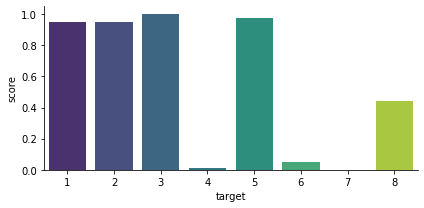

In [59]:
sns.catplot(x='target', y='score',
            kind="bar", data=df_cross,
            # data=df_cross[df_cross['estimator'] == 'CSP-LDA'], 
            palette='viridis', height=3, aspect=2)

# Predictions within subjects

In [10]:
n_jobs = -1
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(8):
    y_train_all.append(d_['MatCoh'][i, 1])

all_pred = []
for s in trange(8):
    X = np.array([i for i in range(120)])
    y_train = y_train_all[s]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    # Patate
    th = 5 # 4
    mat = FeatConn("Coh", s, "test").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcoh = (pt.predict(mat) == 1)
    mat = FeatConn("Cov", s, "test").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcov = (pt.predict(mat) == 1)
    mat = FeatConn("PLV", s, "test").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfplv = (pt.predict(mat) == 1)
    atf = np.logical_and(atfcoh, np.logical_and(atfcov, atfplv))
    print ("removed ", len(X)-atf.sum(), "artefacts")
    X_train = X[:80]
    X_train = X_train[atf[:80]]
    # On n'applique pas la patate pour X_test car on doit prédire tout
    X_test = X[80:]
    y_train = y_train[atf[:80]]

    pipelines = {}
    pipelines['fgMDM-Coh'] = make_pipeline(
        FeatConn("Coh", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-PLV'] = make_pipeline(
        FeatConn("PLV", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-Cov'] = make_pipeline(
        FeatConn("Cov", s, "test"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    estimators = [('cov', pipelines['fgMDM-Cov']),
                  ('coh', pipelines['fgMDM-Coh']),
                  ('plv', pipelines['fgMDM-PLV'])
                 ]
    final_estimator = RidgeClassifier(class_weight="balanced")
    cvkf = StratifiedKFold(n_splits=5, shuffle=True)
    scl = StackingClassifier(estimators=estimators,
            cv=cvkf, n_jobs=n_jobs, final_estimator=final_estimator,
            stack_method='predict_proba')
    pipelines['Ensemble'] = scl

    pipelines['Ensemble'].fit(X_train, y_train)
    y_pred = pipelines['Ensemble'].predict(X_test)
    y_pred = le.inverse_transform(y_pred)
    for i, yp in enumerate(y_pred):
        res = {"subject name": "P{:02d}".format(s+1),
               "trial index": i+1,
               "prediction": yp}
        all_pred.append(res)
df_pred = pd.DataFrame(all_pred)    

removed  1 artefacts
removed  0 artefacts
removed  0 artefacts
removed  0 artefacts
removed  0 artefacts
removed  2 artefacts
removed  0 artefacts
removed  1 artefacts



In [17]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('results-within.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
for s in df_pred['subject name'].unique(): 
    df_pred[df_pred['subject name'] == s].to_excel(writer, sheet_name=s, index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Prediction cross-subjects

In [ ]:
n_jobs = 1
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(8):
    y_train_all.append(d_['MatCoh'][i, 1])

cross_subj = []
for s in trange(8):
    X = np.array([i for i in range(80)])
    y_train = y_train_all[s]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    # Patate
    th = 3 # 4
    mat = FeatConn("Coh", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcoh = (pt.predict(mat) == 1)
    mat = FeatConn("PLV", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfplv = (pt.predict(mat) == 1)
    mat = FeatConn("Cov", s, "train").fit_transform(X)
    pt = Potato(metric='logeuclid', threshold=th).fit(mat)
    atfcov = (pt.predict(mat) == 1)
    atf = np.logical_and(atfcoh, np.logical_and(atfcov, atfplv))
    print ("removed ", len(X)-atf.sum(), "artefacts")
    X_train = X[:80]
    X_train = X_train[atf[:80]]
    # On n'applique pas la patate pour X_test car on doit prédire tout
    # X_test = X[60:]
    y_train = y_train[atf[:80]]

    pipelines = {}
    pipelines['fgMDM-Coh'] = make_pipeline(
        FeatConn("Coh", s, "train"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-PLV'] = make_pipeline(
        FeatConn("PLV", s, "train"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['fgMDM-Cov'] = make_pipeline(
        FeatConn("Cov", s, "train"),
        FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=n_jobs))
    pipelines['CSP-LDA'] = make_pipeline(
        FeatConn("signal", s),
        CSP(n_components=6, reg='ledoit_wolf'), 
        LDA())
    estimators = [('cov', pipelines['fgMDM-Cov']),
                  ('coh', pipelines['fgMDM-Coh']),
                  ('plv', pipelines['fgMDM-PLV'])
                 ]
    final_estimator = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, intercept_scaling=1000., solver='saga') # RidgeClassifier(class_weight="balanced")
    cvkf = StratifiedKFold(n_splits=5, shuffle=True)
    scl = StackingClassifier(estimators=estimators,
            cv=cvkf, n_jobs=n_jobs, final_estimator=final_estimator,
            stack_method='predict_proba')
    pipelines['Ensemble'] = scl

    pipelines['CSP-LDA'].fit(X_train, y_train)
    pipelines['Ensemble'].fit(X_train, y_train)
    cross_subj.append({'X_train': X_train, 'y_train': y_train, 
                       'pipelines': pipelines, 
                       'mean': mean_covariance(mat[atf], metric='riemann', sample_weight=None)})

# TODO: read data from files
cross_subj.append({'mean': mean_covariance(mat[atf], metric='riemann', sample_weight=None)})
cross_subj.append({'mean': mean_covariance(mat[atf], metric='riemann', sample_weight=None)})

all_res = []
for target in trange(8,10):
    best = np.argmin(np.array([distance(cross_subj[source]['mean'],
                                        cross_subj[target]['mean'], metric='riemann')
                               for source in range(8) if source != target]))
    yens = cross_subj[best]['pipelines']['Ensemble'].predict(cross_subj[target]['X_train'])
    for i, yp in enumerate(yens):
        res = {"subject name": "P{:02d}".format(target+1),
               "trial index": i+1,
               "prediction": yp}
        all_pred.append(res)
df_pred_cross = pd.DataFrame(all_res)

In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('results-cross.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
for s in df_pred_cross['subject name'].unique(): 
    df_pred_cross[df_pred_cross['subject name'] == s].to_excel(writer, sheet_name=s, index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Complementary results

In [245]:
# cvkf = StratifiedKFold(n_splits=4 au lieu de 5, shuffle=True) et 
# RepeatedStratifiedKFold(n_splits=4, n_repeats=5 au lieu de 10,

print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Coh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Cov']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-PLV']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy())*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 60.19
FgMDM on covariance       = 64.94
FgMDM on phase-lock value = 57.00
---------------------------------
Ensemble classifier       = 71.93

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1000.0, l1_ratio=0.1, max_iter=100,
        

In [134]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
CSP+LDA on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Coh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Cov']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-PLV']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'CSP-LDA']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy())*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 59.68
FgMDM on covariance       = 66.05
FgMDM on phase-lock value = 58.01
CSP+LDA on covariance     = 57.91
---------------------------------
Ensemble classifier       = 69.30

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=7)),
                ('fgmdm2', FgMDM2(metric='riemann', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=7)),
                ('fgmdm2', FgMDM2(metric='riemann', n_jobs=-1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=7)),
                ('fgmdm2', FgMDM2(metric='riemann', n_jobs=-1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1000.0, l1_ratio=0.1, max_iter=100,
                   multi_cla

In [264]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
MDM on AEC                = {:.2f}
MDM on im coherence       = {:.2f}
CSP+LDA on covariance     = {:.2f}
CSP+SVM on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Coh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-Cov']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'fgMDM-PLV']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'MDM-AEC']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'MDM-ICoh']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'CSP-LDA']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'CSP-SVM']['score'].to_numpy())*100,
    np.nanmean(df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy())*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 60.19
FgMDM on covariance       = 64.94
FgMDM on phase-lock value = 57.00
MDM on AEC                = 7.31
MDM on im coherence       = 16.75
CSP+LDA on covariance     = 58.06
CSP+SVM on covariance     = nan
---------------------------------
Ensemble classifier       = 71.33

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=7)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0,

/home/sylchev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


## bad results

In [158]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    df_strat[df_strat['estimator'] == 'Coh']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Cov']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'PLV']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy().mean()*100))

print(scl.estimators)
print(scl.final_estimator)


Kappa score
FgMDM on coherence        = 52.44
FgMDM on Covariance       = 50.00
FgMDM on Phase-Lock Value = 50.88
---------------------------------
Ensemble classifier       = 58.69

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1000.0, l1_ratio=0.1, max_iter=100,
        

In [217]:
print ("""
play with l1_ratio -> 0.1 instead of 0.1

Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
CSP+LDA on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    df_strat[df_strat['estimator'] == 'Coh']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Cov']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'PLV']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'CSP']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy().mean()*100))

print(scl.estimators)
print(scl.final_estimator)


play with l1_ratio -> 0.1 instead of 0.1

Kappa score
FgMDM on coherence        = 52.44
FgMDM on covariance       = 50.00
FgMDM on phase-lock value = 50.88
CSP+LDA on covariance     = 43.06
---------------------------------
Ensemble classifier       = 57.69

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     

In [212]:
print ("""
play with l1_ratio -> 0.2 instead of 0.1

Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on covariance       = {:.2f}
FgMDM on phase-lock value = {:.2f}
CSP+LDA on covariance     = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}

Classifiers
===========""".format(
    df_strat[df_strat['estimator'] == 'Coh']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Cov']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'PLV']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'CSP']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy().mean()*100))

print(scl.estimators)
print(scl.final_estimator)


play with l1_ratio -> 0.2 instead of 0.1

Kappa score
FgMDM on coherence        = 52.44
FgMDM on covariance       = 50.00
FgMDM on phase-lock value = 50.88
CSP+LDA on covariance     = 43.06
---------------------------------
Ensemble classifier       = 58.06

Classifiers
[('cov', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Cov', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('coh', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='Coh', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False)), ('plv', Pipeline(memory=None,
         steps=[('featconn', FeatConn(feat='PLV', subj=0)),
                ('fgmdm2',
                 FgMDM2(metric='logeuclid', n_jobs=1, tsupdate=True))],
         verbose=False))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     

# Dead code

In [38]:
s = 0
X = np.array([i for i in range(80)])
y = y_train_all[s]
le = LabelEncoder()
y = le.fit_transform(y)
all_res = []

rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1)
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipelines['fgMDM-Coh'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-Coh'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "Coh"}
    all_res.append(res)
    pipelines['fgMDM-Cov'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-Cov'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "Cov"}
    all_res.append(res)
    pipelines['fgMDM-PLV'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-PLV'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "PLV"}
    all_res.append(res)
df_s0 = pd.DataFrame(all_res)

In [219]:
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(0, 8):
    y_train_all.append(d_['MatCoh'][i, 1])
X = np.array([i for i in range(80)])

all_res = []
for s in trange(8):
    y = y_train_all[s]
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    for p in pipelines:
        scores = cross_val_score(pipelines[p], X, y, n_jobs=-1,
                                 scoring=make_scorer(cohen_kappa_score), 
                                 cv=RepeatedStratifiedKFold(n_splits=4, 
                                                            n_repeats=5,
                                                            random_state=1))
        for sc in scores:
            res = {'subject': str(s+1),
                   'score': sc,
                   'estimator': p}
            all_res.append(res)
df_strat = pd.DataFrame(all_res)            

    sc_coh = cross_val_score(pipelines['fgMDM-Coh'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_cov = cross_val_score(pipelines['fgMDM-Cov'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_plv = cross_val_score(pipelines['fgMDM-PLV'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    #sc_csp = cross_val_score(pipelines['CSP-LDA'], X, y, n_jobs=-1,
    #                         scoring=make_scorer(cohen_kappa_score), 
    #                         cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_scl = cross_val_score(scl, X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    #for s_coh, s_cov, s_plv, s_csp, s_scl in zip(sc_coh, sc_cov, sc_plv, sc_csp, sc_scl):
    for s_coh, s_cov, s_plv, s_scl in zip(sc_coh, sc_cov, sc_plv, sc_scl):
        res = {'subject': str(s+1),
               'score': s_coh,
               'estimator': "Coh"}
        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_cov,
               'estimator': "Cov"}
        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_plv,
               'estimator': "PLV"}
        all_res.append(res)
#        res = {'subject': str(s+1),
#               'score': s_csp,
#               'estimator': "CSP"}
#        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_scl,
               'estimator': "Ensemble"}
        all_res.append(res)
df_strat = pd.DataFrame(all_res)

In [88]:
from pyriemann.utils.mean import mean_riemann

for s in range(8):
    print ("subj = ", s)
    mat = FeatConn("Coh", s).transform(X)
    pt = Potato(metric='logeuclid', threshold=5, pos_label=1, neg_label=0).fit(mat)
    artefact = (pt.predict(mat) == 1)
    print ("il y a ", len(mat)-artefact.sum(), "artefacts")
    #fig, axes = plt.subplots(8, 10, figsize=(10, 10))
    #for i, ax in enumerate(axes.flatten()):
    #    if not artefact[i]: ax.imshow(mat[i], cmap="magma")
    #    else: ax.imshow(mat[i], cmap="viridis")
    #    ax.axis('off')
    #plt.figure()
    #plt.imshow(mean_riemann(mat[artefact]), cmap="viridis")
    mean_riemann(mat[artefact])
    print('ok coh')

subj =  0
il y a  1 artefacts
ok coh
subj =  1
il y a  0 artefacts
ok coh
subj =  2
il y a  0 artefacts
ok coh
subj =  3
il y a  0 artefacts
ok coh
subj =  4
il y a  0 artefacts
ok coh
subj =  5
il y a  1 artefacts
ok coh
subj =  6
il y a  0 artefacts
ok coh
subj =  7
il y a  1 artefacts
ok coh


# Ideas

- [ ] test linear_model.RidgeClassifier
- [X] inclure CSP+LDA -> bof, baisse les résultats
- [X] include ICoh, AEC en MDM -> Bof, baisse les résultats
- [X] logeuclidian converge alors que AIRM non !
- [X] tester avec la patate riemannienne -> pas mal ! 
- [ ] regarder le signal des sujets
- [X] Graphical Lasso pour estimer la matrice de covariance => Trop lent !